# **Convolutional Tensor Train LSTM**  

**Authors**:  
Ferdinand Bhavsar  
Antoine Nicolai  
Tom Mechinau  
Geoffrey Bossut  
Guillaum Blassel  
Dorian Poncet  

**Reproduction Challenge -- REMA**  
*Original paper and code*: https://sites.google.com/nvidia.com/conv-tt-lstm

## Imports

In [1]:
# Imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPool2D, Dense, Flatten, AvgPool2D, Layer, Add, ZeroPadding3D, LSTMCell
from tensorflow.keras import optimizers
import tensorflow as tf

import numpy as np

from tqdm import tqdm
import requests
import os

## Imports to save or load weight from Google Drive ==> For colab
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

google_drive_save_weights=False
google_drive_load_weight=False


## **Data**

**Load the Moving-MNIST data**  
Source: http://www.cs.toronto.edu/~nitish/unsupervised_video/

In [2]:
import torch

X = np.arange(10000)
X = X.reshape((2,5,2,5,-1)) # 2,5,100

tfx = tf.convert_to_tensor(X)
torchx = torch.from_numpy(X)

torchx = torch.split(torchx, 20, -1) # last axis divided in groups of 20
tfx = tf.split(tfx, 5, axis=-1) # last axis splitted in 5

#torchx #torchx.shape
[ t.shape for t in torchx ], [ t.shape for t in tfx ]
assert len(torchx) == len(tfx), "Invalid len !"
for i in range(len(torchx)):
  if not np.array_equal(torchx[i].numpy(),tfx[i].numpy()):
    raise RuntimeError("Invalid data !")

In [3]:
dataset = "./data/mnist_test_seq.npy"

if not os.path.exists('./data'):
    os.mkdir('./data')
    
# Download data
if not os.path.exists(dataset):
    r = requests.get("http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy")
    open(dataset, 'wb').write(r.content)


In [4]:
# Load the Data

assert os.path.exists(dataset), "ASSERT ERROR: The file does not exist."
data = np.float32(np.load(dataset) / 255.0)

data = np.swapaxes(data, 0, 1)
data = np.expand_dims(data, -1)

data_samples = data.shape[0]

data_frames  = data.shape[1]

**Data visualisation function**

In [5]:
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

def plot_sequence_images(image_array):
    dpi = 72.0
    xpixels, ypixels = image_array[0].shape[:2]
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        if image_array[i].shape[-1] == 1:
            image = image_array[i][:,:,0]
        else:
            image = image_array[i]
        im.set_array(image)
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array), interval=33, repeat_delay=1, repeat=True)
    display(HTML(anim.to_html5_video()))

In [6]:
plot_sequence_images(data[0])

<Figure size 64x64 with 0 Axes>

**Data shapes**

In [7]:
display(data_samples, data_frames)
display(data.shape)

10000

20

(10000, 20, 64, 64, 1)

## **Model**

The Layer

In [8]:
class ConvTTLSTMLayer(Layer):
    def __init__(self, input_channels, hidden_channels,
                      order=3, steps=3, ranks=8,
                      kernel_size=(5, 5), bias=True):
        super(ConvTTLSTMLayer, self).__init__()
        
        ## Calling Parameters // Initializes later
        #self.hidden_states = None
        #self.hidden_state_index = 0
        #self.cell_states = None

        ## Input/output interfaces
        self.input_channels  = input_channels
        self.hidden_channels = hidden_channels
        
        # Number of hidden states taken
        self.steps = steps
        # Number of G matrices
        self.order = order
        # How many hidden step by group to be preprocessed together
        self.lags = steps - order + 1

        # Paddding
        padding_shape = (kernel_size[0] // 2, kernel_size[1] // 2, 0)
        
        # Change to 3D ? Same effecct but different optimisations
        preprocessing_Conv3D = lambda out_channels, name:  Conv3D(filters=out_channels,
                                                            kernel_size=kernel_size + (self.lags,),
                                                            padding='valid',
                                                            #activation="relu", #No activation in original paper ?
                                                            use_bias=bias, name=name)
    
        tt_Conv2D = lambda out_channels, name:  Conv2D(filters=out_channels,
                                                  kernel_size=kernel_size,
                                                  padding='same',
                                                  #activation="relu", #No activation in original paper ?
                                                  use_bias=bias, name=name)

        self.layers_preprocess_padding = []
        self.layers_preprocess = []
        self.layers_conv2d = []
        
        for l in range(order+1):
            self.layers_preprocess_padding.append(ZeroPadding3D(padding=padding_shape))
            self.layers_preprocess.append(preprocessing_Conv3D(out_channels = ranks, name='preproc_conv_{}'.format(l)))

            self.layers_conv2d.append(tt_Conv2D(out_channels = ranks if l < order - 1 else 4 * hidden_channels, name='conv_{}'.format(l)))

    def initialize(self, inputs):
        '''
        Initialize the hidden cell states H
        '''
            
        batch_size, height, width, input_channels = inputs.shape
            
        self.hidden_states = [tf.zeros([batch_size, 
            height, width, self.hidden_channels]) for t in range(self.steps)]
        self.hidden_state_index = 0
        self.cell_states = tf.zeros([batch_size,
            height, width, self.hidden_channels])
        
    def call(self, inputs, first_call=False):
        '''
        Call the model
        '''
        if first_call:
            self.initialize(inputs)
            first_call = False
            
        ## Preprocessing + Convolutional tensor-train module
        ## Algorithm 2

        for i in range(self.order):
            input_pointer = self.hidden_state_index if i == 0 else (input_pointer + 1) % self.steps
                
            # Start hidden states input at pointer but wrap around
            input_states = self.hidden_states[input_pointer:] + self.hidden_states[:input_pointer]
            
            # Take one group of Hidden States
            # TS ==> Channel Last
            # Pytorch ==> Channel First
            input_states = input_states[:self.lags]
            input_states = tf.stack(input_states, axis=-2)

            input_states = self.layers_preprocess_padding[i](input_states)
            input_states = self.layers_preprocess[i](input_states)
            input_states = tf.squeeze(input_states, axis=-2)
            
            
            if i == 0:
                temp_states = input_states
            else: # if i > 0
                temp_states = input_states + self.layers_conv2d[i - 1](temp_states)
            
        ## Standard convolutional-LSTM module
        concat_conv = self.layers_conv2d[-1](tf.concat([inputs, temp_states], axis=-1))
        #print(concat_conv.shape) # FIXME: remove me
        cc_i, cc_f, cc_o, cc_g = tf.split(concat_conv, 4, axis=-1)
        #print([ e.shape for e in [cc_i, cc_f, cc_o, cc_g] ]) # FIXME: remove me
        

        
        i = tf.math.sigmoid(cc_i)
        f = tf.math.sigmoid(cc_f)
        o = tf.math.sigmoid(cc_o)
        g = tf.math.tanh(cc_g)
        
        self.cell_states = f * self.cell_states + i * g
        outputs = o * tf.tanh(self.cell_states)
        self.hidden_states[self.hidden_state_index] = outputs
        self.hidden_state_index = (self.hidden_state_index + 1) % self.steps

        return outputs

In [9]:
input_shape = (64, 64, 1)
convttlstm = ConvTTLSTMLayer(3,3)
#convttlstm.build((50, *input_shape))

The network

In [10]:
class ConvTTLSTMNet(Model):
    def __init__(self,
                 input_channels,
                 layers_per_block:list, hidden_channels:list, skip_stride = None,
                 # Params for the TTLSTM
                 order=3, steps=3, ranks=8,
                 kernel_size = (5,5), bias = True,
                 output_sigmoid = False):
        super(ConvTTLSTMNet, self).__init__()
        
        ## Hyperparameters
        self.layers_per_block = layers_per_block
        self.hidden_channels  = hidden_channels

        self.num_blocks = len(layers_per_block)
        assert self.num_blocks == len(hidden_channels), "Invalid number of blocks."
        
        ## If None no stride (Stride is bigger than block nb, so is never skipped)
        self.skip_stride = (self.num_blocks + 1) if skip_stride is None else skip_stride

        self.output_sigmoid = output_sigmoid
        
        self.layers_ = {}

        # Model Architecture
        for b in range(self.num_blocks):
            for l in range(layers_per_block[b]):
                # number of input channels to the current layer
                if l > 0:
                    channels = hidden_channels[b]
                elif b == 0:
                    channels = input_channels
                else:
                    # First layer of a block after the first one
                    channels = hidden_channels[b - 1]
                    if b > self.skip_stride:
                      channels += hidden_channels[b-1-self.skip_stride] 
                
                # We keep the layer id for skip connections
                # FIXME ? Maybe there's something to do that with Keras ? Unsure
                lid = "b{}l{}".format(b, l)
                
                cttlstmlayer = ConvTTLSTMLayer(
                    input_channels = channels, hidden_channels = hidden_channels[b],
                    order = order, steps = steps, ranks = ranks, 
                    kernel_size = kernel_size, bias = bias)
                
                self.layers_[lid] = cttlstmlayer
                
        # Last Layer
        # nb of input
        channels = hidden_channels[-1]
        
        # Si il y a plus de blocks que la distance de skip, alots on ajoute à l'input
        if self.num_blocks >= self.skip_stride:
            channels += hidden_channels[-1-self.skip_stride]
            
        if False: #self.output_sigmoid:
            activation="sigmoid"
        else:
            activation=None
            
        self.layers_["output"] = Conv2D(input_channels, kernel_size=(1,1), 
                                       activation=activation, padding="valid", use_bias=True, trainable=True)
        
    
    def initialize_calling_params(self, input_frames:int, future_frames:int, output_frames:int, teacher_forcing = False, scheduled_sampling_ratio = 0):
      self.input_frames = input_frames
      self.future_frames = future_frames
      self.output_frames = output_frames
      self.teacher_forcing = teacher_forcing
      self.scheduled_sampling_ratio = scheduled_sampling_ratio

    def call(self, inputs):
        if self.teacher_forcing and self.scheduled_sampling_ratio > 1e-6:
            teacher_forcing_mask = np.random.binomial(size=(inputs.shape[0], self.future_frames - 1, 1, 1, 1), n=1, p=self.scheduled_sampling_ratio)
        else:
            self.teacher_forcing = False
            print("WARNING: Teacher Forcing to False")
            
        total_steps = self.input_frames + self.future_frames - 1
        outputs = [None] * total_steps

        for t in range(total_steps):
            if t < self.input_frames: 
                input_ = inputs[:, t]
            elif not self.teacher_forcing:
                input_ = outputs[t-1]
            else: # if t >= input_frames and teacher_forcing:
                mask = teacher_forcing_mask[:, t - self.input_frames]
                input_ = inputs[:, t] * mask + outputs[t-1] * (1 - mask)

                    
            first_step = (t == 0)

            queue = []

            for b in range(self.num_blocks):
                for l in range(self.layers_per_block[b]):
                    lid = "b{}l{}".format(b, l)
                    input_ = self.layers_[lid](input_, first_call=first_step)

                queue.append(input_)
                if b >= self.skip_stride:
                    input_ = tf.concat([input_, queue.pop(0)], axis=-1)


            
            outputs[t] = self.layers_["output"](input_)
            if self.output_sigmoid:
              outputs[t] = tf.math.sigmoid(outputs[t])

        outputs = outputs[-self.output_frames:]

        outputs = tf.stack([outputs[t] for t in range(self.output_frames)], axis = 1)

        return outputs

## **Training Hyperparameters**  
Based on the original authors hyper-parameters  
Also includes the parameters for the Teacher-Forcing and Learning Rate Decay for training

In [11]:
image_channels = 1
batch_size = 50
predict_frames = 50
input_shape = (batch_size, 20, 64, 64, 1)
batch = data[:batch_size]
convttlstm = ConvTTLSTMNet(1, [3,3,3,3], [32,48,48,32], skip_stride=2)
convttlstm.initialize_calling_params(10, predict_frames, predict_frames)

In [12]:
outputs = convttlstm.call(batch)
plot_sequence_images(outputs[2])
outputs.shape

TensorShape([50, 50, 64, 64, 1])

<Figure size 64x64 with 0 Axes>

In [13]:
plot_sequence_images(data[2])

<Figure size 64x64 with 0 Axes>

In [73]:
# Model parameters and hyper-parameters
## Hyper-parameters given by authors
num_training_iterations = 1
batch_size = 6
## Output len Y 
seq_len = 10
## Input len X
input_len=10
order=3
steps=3
ranks=8
kernel_size = (5,5)
bias=True
output_sigmoid=False
clipping_threshold=3.0

## Decay ratio for learning rate
lr_decay_mode=False
lr_decay_ratio=0.90
lr_decay_epoch=100
min_epoch_decay = 0
## Starting lf
learning_rate=1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)

## Decay ratio for Scheduled Sampling Ratio
ssr_decay_mode=False
ssr_decay_ratio=0.10#4e-3
ssr_decay_epoch=200
# Starting ssr
scheduled_sampling_ratio=1.0


# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

**Loss function defined in the paper**   
It's a l1 + l2 loss

In [74]:
# Optimizer and Loss function 
# Loss is based on the paper
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

def compute_loss(y_pred, y_true):
    mse = MeanSquaredError()
    mae = MeanAbsoluteError()

    l1_loss = mae(y_true, y_pred)
    l2_loss = mse(y_true, y_pred)
    loss = l1_loss + l2_loss

    return loss

optimizer = tf.keras.optimizers.Adam(learning_rate)

In [75]:
## CREATE THE MODEL
input_shape = (batch_size, 20, 64, 64, 1)
convttlstm = ConvTTLSTMNet(1, [3,3,3,3], [32,48,48,32],
                            order=3, steps=3, ranks=8, kernel_size = (5,5),
                            bias=True, output_sigmoid=False, skip_stride=2)
convttlstm.initialize_calling_params(input_frames=input_len, future_frames=seq_len,
                            output_frames=seq_len, teacher_forcing = True,
                            scheduled_sampling_ratio=1.0)
convttlstm.build(input_shape)

In [76]:
convttlstm.summary()

Model: "conv_ttlstm_net_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_ttlstm_layer_62 (ConvTT multiple                  51368     
_________________________________________________________________
conv_ttlstm_layer_63 (ConvTT multiple                  150568    
_________________________________________________________________
conv_ttlstm_layer_64 (ConvTT multiple                  150568    
_________________________________________________________________
conv_ttlstm_layer_65 (ConvTT multiple                  224232    
_________________________________________________________________
conv_ttlstm_layer_66 (ConvTT multiple                  301032    
_________________________________________________________________
conv_ttlstm_layer_67 (ConvTT multiple                  301032    
_________________________________________________________________
conv_ttlstm_layer_68 (ConvTT multiple            

**Create the Test and Train dataset**

In [77]:
import math

np.random.shuffle(data)

train_size = math.ceil(data_samples * 0.70)
test_size = data_samples - train_size

train_data = data[train_size:]
test_data = data[:test_size]

Batch Generator

In [78]:
# Generate a random batch

def make_batch(data, output_frames=10, input_frames=10, batch_size=350):
    inputs = []
    outputs = []
    random_indexes = np.random.choice(data.shape[0], batch_size)
    for j in random_indexes:
      for i in range(0, data.shape[1] - output_frames, input_frames):
        #print("ORIGINAL", data[j, i:].shape)
        #print(data[j, i+input_frames-1:i+input_frames+output_frames-1].shape)
        inputs += [np.concatenate([data[j, i:], data[j, :i]])]
        outputs += [data[j, i+input_frames-1:i+input_frames+output_frames-1]]
        
    inputs = np.array(inputs)
    outputs = np.array(outputs)    
    
    return inputs, outputs

batch_input, batch_output = make_batch(train_data, output_frames=10, input_frames=10)
display(batch_input.shape, batch_output.shape)

(350, 20, 64, 64, 1)

(350, 10, 64, 64, 1)

In [79]:
print("Input\n")
plot_sequence_images(batch_input[0])
print("Output\n")
plot_sequence_images(batch_output[0])

Input



Output



<Figure size 64x64 with 0 Axes>

<Figure size 64x64 with 0 Axes>

## Training Loop




In [84]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_pred = convttlstm(x)
        loss = compute_loss(y_pred, y)
        grads = tape.gradient(loss, convttlstm.trainable_variables)
        #print(grads[1][0])

    capped_grads, _ = tf.clip_by_global_norm(grads, clipping_threshold)

    optimizer.apply_gradients(zip(capped_grads, convttlstm.trainable_variables))

    return loss

# TRAINING LOOP FONCTION
## 2500 Iter is the best we could find (the more the better apparently ?)
## If plot_history is true, will plot the curve of the loss evolution
def train_model(num_training_iterations=2500, plot_history=True, lr_decay_mode=False):
  history = []
  loss = 0
  loop = tqdm(range(0, num_training_iterations), total = num_training_iterations)
  for epoch in loop:
    if lr_decay_mode and (epoch + 1) % lr_decay_epoch == 0:
        tf.keras.backend.set_value(optimizer.learning_rate,
                                optimizer.learning_rate * lr_decay_ratio)

    samples = 0

    output_frames = 10
    input_frames = 10

    frames = make_batch(train_data, output_frames=output_frames, input_frames=input_frames, batch_size=batch_size)[0]

    samples += batch_size

    inputs = frames[:, :-1]
    origin = frames[:, -output_frames:]

    #print(inputs.shape)

    loss = train_step(inputs, origin)

    if ssr_decay_mode and (epoch + 1) % ssr_decay_epoch == 0:
      scheduled_sampling_ratio = max(scheduled_sampling_ratio - ssr_decay_ratio, 0)
      convttlstm.scheduled_sampling_ratio = scheduled_sampling_ratio

    if not lr_decay_mode and epoch > 400:
      lr_decay_mode = True

    if plot_history:
      history.append(loss.numpy().mean())

      plt.plot(history)

    loop.set_description(f"Epoch [{epoch}/{num_training_iterations}]")
    loop.set_postfix(loss= loss.numpy().mean())

  return loss.numpy().mean()

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.

Epoch [666/1500]:  44%|████▍     | 667/1500 [44:54<54:54,  3.96s/it, loss=0.0445]

Epoch [667/1500]:  44%|████▍     | 667/1500 [44:58<54:54,  3.96s/it, loss=0.0445]

Epoch [667/1500]:  44%|████▍     | 667/1500 [44:58<54:54,  3.96s/it, loss=0.0404]

Epoch [667/1500]:  45%|████▍     | 668/1500 [44:58<54:52,  3.96s/it, loss=0.0404]

Epoch [668/1500]:  45%|████▍     | 668/1500 [45:02<54:52,  3.96s/it, loss=0.0404]

Epoch [668/1500]:  45%|████▍     | 668/1500 [45:02<54:52,  3.96s/it, loss=0.0392]

Epoch [668/1500]:  45%|████▍     | 669/1500 [45:02<54:45,  3.95s/it, loss=0.0392]

Epoch [669/1500]:  45%|████▍     | 669/1500 [45:06<54:45,  3.95s/it, loss=0.0392]

Epoch [669/1500]:  45%|████▍     | 669/1500 [45:06<54:45,  3.95s/it, loss=0.0456]

Epoch [669/1500]:  45%|████▍     | 670/1500 [45:06<54:42,  3.95s/it, loss=0.0456]

Epoch [670/1500]:  45%|████▍     | 670/1500 [45:10<54:42,  3.95s/it, loss=0.0456]

Epoch [6

<tf.Tensor: shape=(), dtype=float32, numpy=0.03315124>

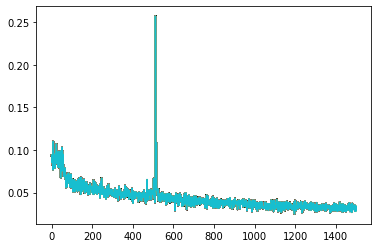

In [85]:
train_model(num_training_iterations=650, plot_history=True)

## Load weight if on GC

In [ ]:
## Load weight if you're on Google Colab and have weight you can import
if google_drive_load_weight:
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  last_weight_file = drive.CreateFile({'id': '16HaEZjw9Cb-BWXmwv-wf_KEGQlKq31eW'}) 
  last_weight_file.GetContentFile('last_weights.mat')
  convttlstm.load_weights('last_weights.mat')


## Testing  
*Testing the model*  
1. Computing the loss on the Training data
2. Visualisation of the data predicted against the Ground Truth, Input and Original

In [89]:
## Remove the Teacher Forcing, because it is a training only method
convttlstm.initialize_calling_params(input_frames=seq_len, future_frames=seq_len,
                            output_frames=seq_len, teacher_forcing = False,
                            scheduled_sampling_ratio =0.0)

In [93]:
convttlstm.compile("adam", loss=compute_loss)
results = convttlstm.evaluate(test_data, test_data[:, :10], batch_size=5)

600/600 [==============================] - 641s 1s/step - loss: 0.1322


**Testing further metrics**

In [94]:
# MSE
convttlstm.compile("adam", loss="mse")
results_mse = convttlstm.evaluate(test_data, test_data[:, :10], batch_size=5)

# SSIM
def ssim(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

convttlstm.compile("adam", loss=ssim)
results_ssim = convttlstm.evaluate(test_data, test_data[:, :10], batch_size=5)

600/600 [==============================] - 642s 1s/step - loss: 0.6430
Test MSE : 0.060035690665245056
Test SSIM : 0.642438530921936


In [95]:
print("Test MSE : {0}\nTest SSIM : {1}".format(results_mse * 1000, results_ssim))

Test MSE : 60.035690665245056
Test SSIM : 0.642438530921936


**Prediction visualisation**

In [90]:
outputs = convttlstm.call(data[:10])

In [91]:
outputs.shape

TensorShape([10, 10, 64, 64, 1])

In [92]:
for i in range(5,10):
  print("Original:\n")
  plot_sequence_images(data[i])
  print("Input:\n")
  plot_sequence_images(data[i, :10])
  print("Ground Truth:\n")
  plot_sequence_images(data[i, 10:])
  print("Prediction:\n")
  plot_sequence_images(outputs[i])
  print("Original + Prediction\:n")
  whole_predict = np.vstack((data[i, :10], outputs[i]))
  plot_sequence_images(whole_predict)


Original:



Input:



Ground Truth:



Prediction:



Original + Prediction\:n


Original:



Input:



Ground Truth:



Prediction:



Original + Prediction\:n


Original:



Input:



Ground Truth:



Prediction:



Original + Prediction\:n


Original:



Input:



Ground Truth:



Prediction:



Original + Prediction\:n


Original:



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


Input:



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


Ground Truth:



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


Prediction:



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


Original + Prediction\:n


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


<Figure size 64x64 with 0 Axes>

<Figure size 64x64 with 0 Axes>

<Figure size 64x64 with 0 Axes>

<Figure size 64x64 with 0 Axes>

<Figure size 64x64 with 0 Axes>

<Figure size 64x64 with 0 Axes>

<Figure size 64x64 with 0 Axes>

<Figure size 64x64 with 0 Axes>

<Figure size 64x64 with 0 Axes>

<Figure size 64x64 with 0 Axes>

<Figure size 64x64 with 0 Axes>

<Figure size 64x64 with 0 Axes>

<Figure size 64x64 with 0 Axes>

<Figure size 64x64 with 0 Axes>

<Figure size 64x64 with 0 Axes>

<Figure size 64x64 with 0 Axes>

<Figure size 64x64 with 0 Axes>

<Figure size 64x64 with 0 Axes>

<Figure size 64x64 with 0 Axes>

<Figure size 64x64 with 0 Axes>

<Figure size 64x64 with 0 Axes>

<Figure size 64x64 with 0 Axes>

<Figure size 64x64 with 0 Axes>

<Figure size 64x64 with 0 Axes>

<Figure size 64x64 with 0 Axes>

## Weight Saving in GC

In [88]:
## Save weight if you're on Google Colab and have weight you can export
if google_drive_save_weights:

  # 1. Authenticate and create the PyDrive client.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  # 2. Save Keras Model or weights on google drive

  convttlstm.save_weights('convttlstm_weights.h5')
  weights_file = drive.CreateFile({'title' : 'convttlstm_weights.h5'})
  weights_file.SetContentFile('convttlstm_weights.h5')
  weights_file.Upload()
  drive.CreateFile({'id': weights_file.get('id')})

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exceptio

## **Tests on epochs**  
Testing how epochs numbers influence Train and Test Loss  
*Can indicate Underfitting and Overfitting*

In [ ]:
epochs_tests = [1, 20, 50, 100, 250, 500, 800]

training_losses = []
test_losses = []

for epochs in epochs_tests:
  convttlstm_ept = ConvTTLSTMNet(1, [3,3,3,3], [32,48,48,32],
                              order=3, steps=3, ranks=8, kernel_size = (5,5),
                              bias=True, output_sigmoid=False, skip_stride=2)
  convttlstm_ept.initialize_calling_params(input_frames=input_len, future_frames=seq_len,
                              output_frames=seq_len, teacher_forcing = True,
                              scheduled_sampling_ratio=0.9)
  convttlstm_ept.build(input_shape)
  
  
  training_loss = train_model(num_training_iterations=epochs, plot_history=False)
  training_losses.append(training_loss)

  convttlstm_ept.compile("adam", loss=compute_loss)
  test_loss = convttlstm_ept.evaluate(test_data, test_data[:, :10], batch_size=5)
  test_losses.append(test_loss)
  print(test_loss)



  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [0/1]:   0%|          | 0/1 [00:04<?, ?it/s]

Epoch [0/1]:   0%|          | 0/1 [00:04<?, ?it/s, loss=0.0304]

Epoch [0/1]: 100%|██████████| 1/1 [00:04<00:00,  4.13s/it, loss=0.0304]
